# Setup

Don't change this cell; setup should remain the same for all data series.

In [1]:
#Imports
import glob, math, time
import numpy as np
import pandas as pd
import lmfit as lf
import statistics as s
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy import signal as sig

#Import custom library included in this repository
from R76Tools import *

#Don't use local mplstyle - it's deprecated!
plt.style.use('./default.mplstyle')

# Set up possible data paths
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"
neogpath = "/data/chocula/neog/rq/"

## Data Selection
Change this cell in order to select and label data.

In [109]:
ser = ["07220830_2033","07220831_1002","07220831_1846","07220909_2023","07220910_1210","07220910_1517","07220912_1955","07220913_0814","07220913_1457","07220914_1133"]
paths = [frittspath,frittspath,frittspath,frittspath,frittspath,frittspath,frittspath,frittspath,frittspath,frittspath]
print(len(ser))
print(len(paths))

10
10


# Load and Plot
Don't change these cells unless you are experiencing issues with the selected binning. (In that case, change the first line of the second cell.)

In [110]:
#Start by importing and organizing our data
e=[]; z=[];
i=0
for series in list(zip(ser,paths)):
    print(i,"/",len(ser),sep="")
    i+=1
    loc = series[1] + series[0]
    e_chain,z_chain = makechain(loc,filters=fittingfilters)
    z_chain = pd.concat([e_chain,z_chain],axis=1)
    z.append(z_chain)
    
for x in z:
    x['crand'] = crand(x)
    x['pt_keV'] = pt_keV(x)
    x['cam'] =  cam(x)
    x['cphi1'] = cphi1(x)
    x['PSUMbs'] = PSUMbs(x)

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


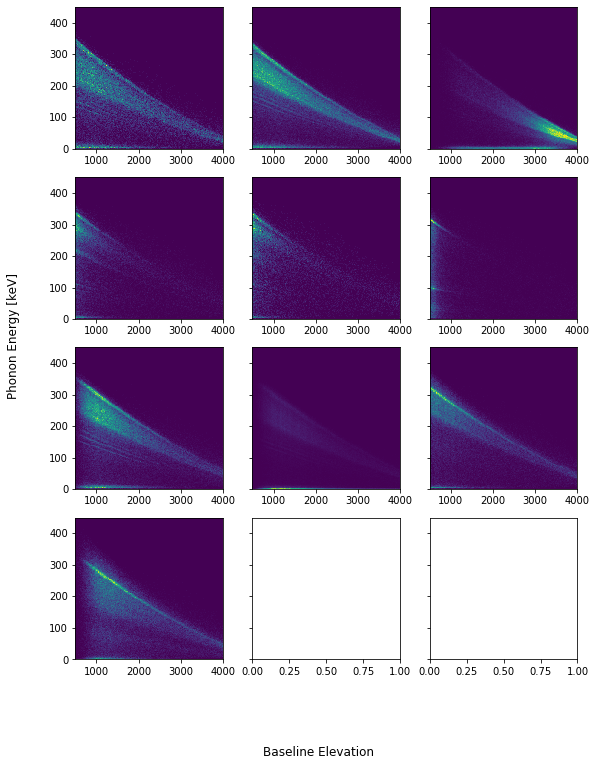

In [111]:
bins = [np.linspace(500,4000,200),np.linspace(0,450,150)]
    
#Plot
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True)
try:
    for i,axarray in enumerate(ax):
        try:
            for j,axis in enumerate(axarray):
                k = j + i*len(axarray)
                if k < len(z): #do nothing if we have an empty corner.
                    axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],bins=bins)
        except TypeError: #Case for when there are multiple entries but only one column.
            k = i
            axarray.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],bins=bins)
except TypeError: #Case for when there is only one entry.
    if len(z) == 1:
        k = 0 #We could squish z from an array to its entry but that gets complicated later on.
        ax.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['pt_keV'][~z[k]['crand']],bins=bins)
    else:
        raise ValueError("axes could not be enumerated twice, or once, but Z had more than one entry... what!!")

fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

## Define points to fit to
Change the first two lines of this cell until you get the lines looking right in the second.

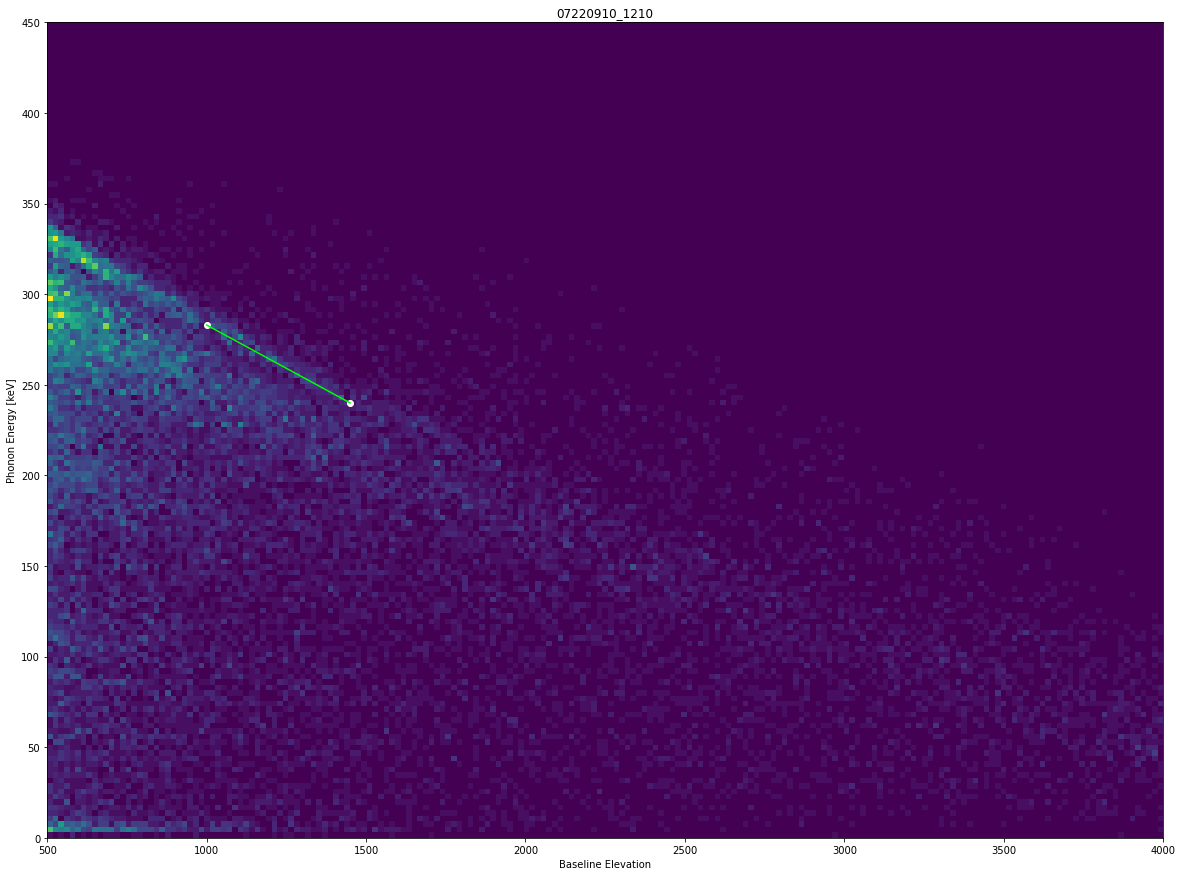

m: -0.09555555555555556 b: 378.55555555555554 10^4*m/b: -2.5242148517757563
07220910_1210, -0.096, 379.0


In [156]:
i=4
points = [[1000,283],[1450,240]] #Some points along one of the lines
x = z[i] #Pick one of the entries in z to use
bins2 = [np.linspace(4000,5000,200),np.linspace(0,80,150)]
bins3 = [np.linspace(500,4000,180),np.linspace(0,50,100)]

fig = plt.figure(figsize=(20,15))
plt.hist2d(x["PSUMbs"][~x["crand"]]-18000, x["pt_keV"][~x["crand"]]#)
           ,bins=bins)
           #,bins = bins2)
           #,bins=bins3)
           #bins=[np.linspace(3000,5000,200),np.linspace(0,100,150)])
m = (points[1][1]-points[0][1])/(points[1][0]-points[0][0]); b = points[0][1] - points[0][0]*m
x = np.linspace(points[0][0],points[1][0],1000)
plt.scatter([points[0][0],points[1][0]],[points[0][1],points[1][1]],color='white')
plt.plot(x,m*x+b,color='lime')
plt.xlabel("Baseline Elevation")
plt.ylabel("Phonon Energy [keV]")
plt.title(ser[i])
plt.show()
print("m:",m,"b:",b,"10^4*m/b:",10000*m/b)
print(ser[i],", ",round(m,3),", ",round(b,0),sep="")

## Check baseline correction

Don't change these cells; they are here to show you the results of your correction only.

In [61]:
for x in z:
    x['bscorr_man'] = bscorr(x,m/b)

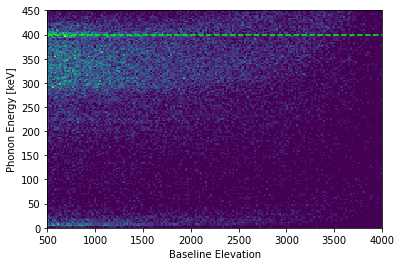

In [62]:
fig = plt.figure()
x = z[-1]
plt.hist2d(x["PSUMbs"][~x["crand"]]-18000, x["bscorr_man"][~x["crand"]]#)
           ,bins=bins)
           #,bins=bins2)
           #,bins = [np.linspace(1500,5000,300),np.linspace(0,100,300)])
plt.axhline(b,linestyle='--',color='lime')
plt.xlabel("Baseline Elevation")
plt.ylabel("Phonon Energy [keV]")
plt.show()

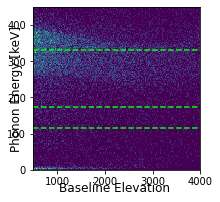

In [22]:
#Plot
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True)
try:
    for i,axarray in enumerate(ax):
        try:
            for j,axis in enumerate(axarray):
                k = j + i*len(axarray)
                if k < len(z): #do nothing if we have an empty corner.
                    axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
                    axis.axhline(points[0][1],linestyle='--',color='lime')
                    axis.axhline(points[1][1],linestyle='--',color='lime')
                    axis.axhline(b,linestyle='--',color='lime')
        except TypeError:
            k = i
            axarray.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
            axarray.axhline(points[0][1],linestyle='--',color='lime')
            axarray.axhline(points[1][1],linestyle='--',color='lime')
            axarray.axhline(b,linestyle='--',color='lime')
except TypeError: #Case for when there is only one entry.
    if len(z) == 1:
        k = 0 #We could squish z from an array to its entry but that gets complicated later on.
        ax.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
        ax.axhline(points[0][1],linestyle='--',color='lime')
        ax.axhline(points[1][1],linestyle='--',color='lime')
        ax.axhline(b,linestyle='--',color='lime')
    else:
        raise ValueError("axes could not be enumerated twice or once but Z had more than one array... what!!")
fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")
plt.show()

This cell is for viewing any individual plot; change as desired.

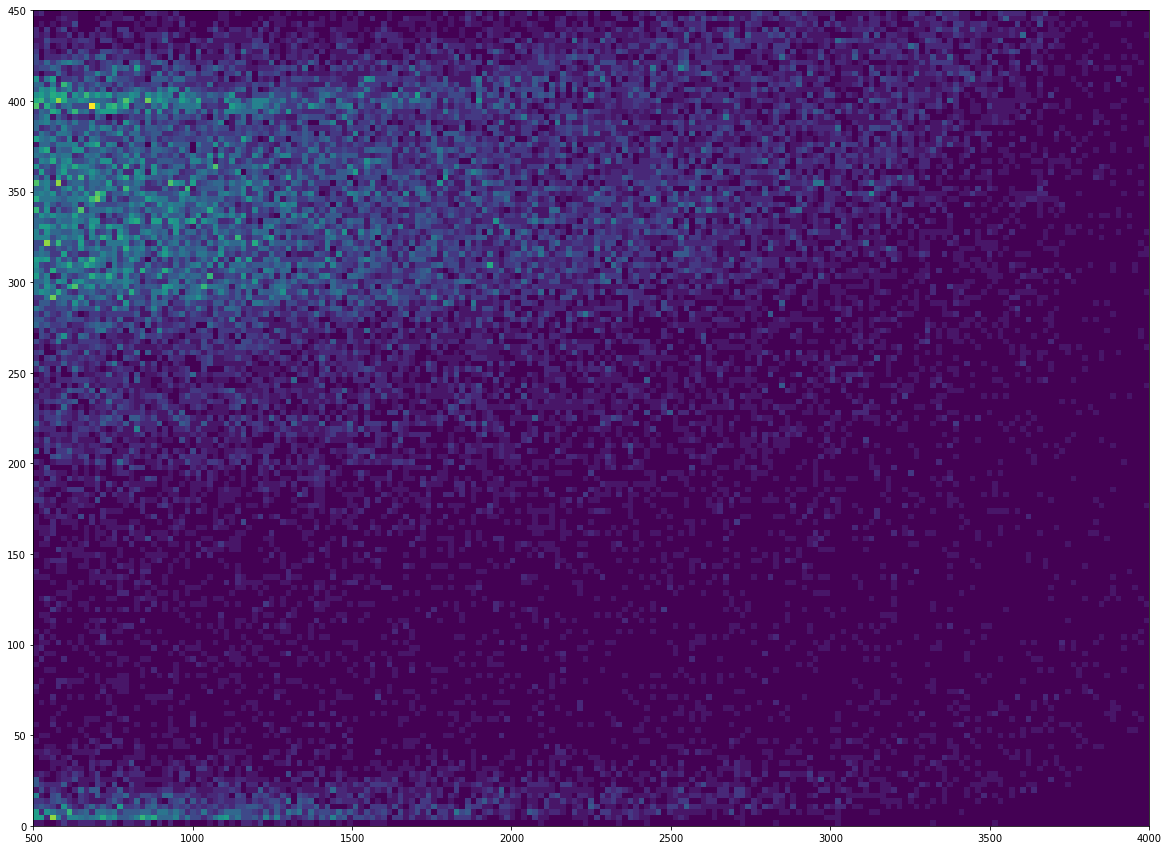

In [63]:
k = 5
fig = plt.figure(figsize=(20,15))
plt.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']]#)
           ,bins=bins)
           #,bins=bins2)
           #,bins = [np.linspace(2000,5000,300),np.linspace(0,450,300)])

'''
plt.axhline(points[0][1],linestyle='--',color='lime')
plt.axhline(points[1][1],linestyle='--',color='lime')
plt.axhline(b,linestyle='--',color='lime')
plt.axhline(320,linestyle='--',color='lime')
plt.axhline(303,linestyle='--',color='lime')
plt.axhline(295,linestyle='--',color='lime')
plt.axhline(175,linestyle='--',color='lime')
plt.axhline(190,linestyle='--',color='lime')
plt.axhline(150,linestyle='--',color='lime')
plt.axhline(0,linestyle='--',color='lime')
'''
plt.show()

### Save or repeat
Either go back up to the "Define points to fit to" section and adjust your points to fix the correction or save the correction information, as printed below, to `baselinecorrectionvalues.csv`.

In [30]:
for series in ser:
    print(series+",",str(m)+",",b)

07220916_2059, -0.1, 425.0
07220925_1006, -0.1, 425.0
07221026_0951, -0.1, 425.0
07221115_0845, -0.1, 425.0
07221124_1408, -0.1, 425.0


# Experimental

While I wait for things to run I am experimenting with an interactive interface for this.

Dropdown(description='Choose series', layout=Layout(width='max-content'), options=(('07220913_1457', 0), ('072…

Checkbox(value=True, description='Automatically go to next step.')

/tmp/ipykernel_2659622/1042552480.py:80: UserWarning: Matplotlib is currently using module://ipympl.backend_nbagg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


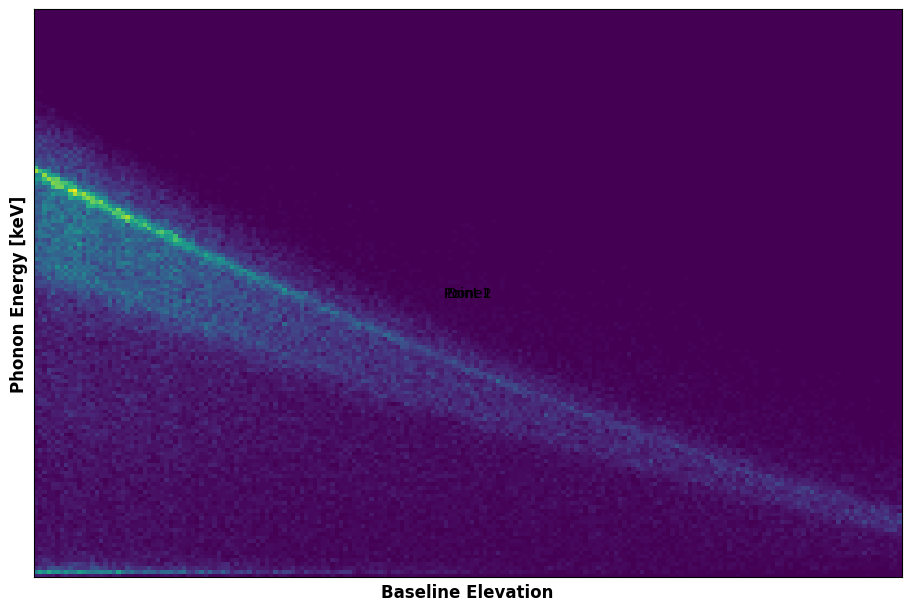

In [46]:
#Imports
from matplotlib.widgets import Button
from ipywidgets.widgets import Dropdown, Checkbox
from IPython.display import display, Javascript

#Set up dropdown for series selection
bor = 0
dd = Dropdown(description = "Choose series",layout={'width': 'max-content'},
              options = [(x,i) for i,x in enumerate(ser)],value=bor)
def dropdown_handler(change):
    global bor
    #print(change.new)
    bor = change.new  # This line isn't working
dd.observe(dropdown_handler, names='value')
display(dd)

#Set up plot
fig,ax = plt.subplots()

#Define buttons
b1 = Button(ax,"Point 1",color='orange'); b2 = Button(ax,"Point 2",color='grey')
bdone = Button(ax,"Done!")
def button1(self,event):
    selectingpoint1 = True
    b1.color = 'orange'; b2.color = 'grey'
def button2(self,event):
    selectingpoint1 = False
    b1.color = 'grey'; b2.color = 'orange'
m,b = 0,0; xvals=[0,0] #placeholder values
def done(self,event):
    global m,b,xvals,z
    m = (points[1][1]-points[0][1])/(points[1][0]-points[0][0])
    b = points[0][1] - points[0][0]*m
    xvals = np.linspace(points[0][0],points[1][0],1000)
    bdone.color = 'b'
    for x in z:
        x['bscorr_man'] = bscorr(x,m/b)
    Javascript("Jupyter.notebook.execute_cells([12])")
b1.on_clicked(button1); b2.on_clicked(button2)
    
#Define click event
point1, point2 = [0,0],[0,0]; autoflip,selectingpoint1 = True, True
def on_pick(event):
    global selectingpoint1, autoflip, point1, point2
    xmouse, ymouse = event.mouseevent.xdata, event.mouseevent.ydata
    if selectingpoint1:
        point1 = [xmouse,ymouse]
        if autoflip:
            b1.color = 'grey'; b2.color = 'orange'
    else:
        point2 = [xmouse,ymouse]
        if autoflip:
            b1.color = 'orange'; b2.color = 'grey'
    if autoflip:
        if not selectingpoint1:
            done()
        selectingpoint1 = !selectingpoint1 #switch to the other point once we've clicked the one we were on
fig.canvas.callbacks.connect('pick_event', on_pick)

#Set up plot
points = [point1,point2]
x = z[bor]
ax.hist2d(x["PSUMbs"][~x["crand"]]-18000, x["pt_keV"][~x["crand"]],
           bins=bins)
           #bins = bins2)
           #bins=[np.linspace(3000,5000,200),np.linspace(0,100,150)])
ax.scatter([points[0][0],points[1][0]],[points[0][1],points[1][1]],color='white')
ax.plot(xvals,m*xvals+[b,b],color='lime')
ax.set_xlabel("Baseline Elevation")
ax.set_ylabel("Phonon Energy [keV]")

#Set up checkboxes
box = Checkbox(True, description="Automatically go to next step.")
display(box)
def change(b):
    global autoflip
    autoflip = !autoflip

#Show plot
fig.show()

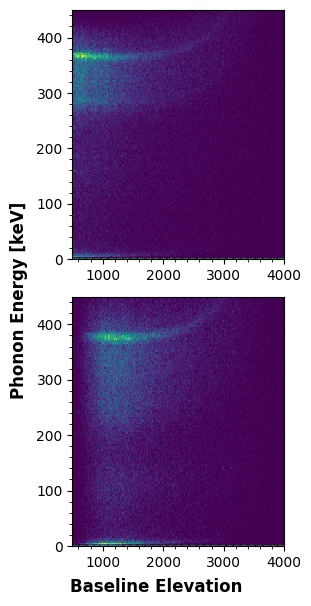

07220913_1457, 0, 0
07220914_1133, 0, 0


In [47]:
#Set up plot
n = len(ser); vert = math.ceil(np.sqrt(n)); hor = math.ceil(n/math.ceil(np.sqrt(n)))
fig,ax = plt.subplots(vert,hor,figsize=(3*hor,3*vert),sharey=True)
try:
    for i,axarray in enumerate(ax):
        try:
            for j,axis in enumerate(axarray):
                k = j + i*len(axarray)
                if k < len(z): #do nothing if we have an empty corner.
                    axis.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
                    axis.axhline(points[0][1],linestyle='--',color='lime')
                    axis.axhline(points[1][1],linestyle='--',color='lime')
                    axis.axhline(b,linestyle='--',color='lime')
        except TypeError:
            k = i
            axarray.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
            axarray.axhline(points[0][1],linestyle='--',color='lime')
            axarray.axhline(points[1][1],linestyle='--',color='lime')
            axarray.axhline(b,linestyle='--',color='lime')
except TypeError: #Case for when there is only one entry.
    if len(z) == 1:
        k = 0 #We could squish z from an array to its entry but that gets complicated later on.
        ax.hist2d(z[k]['PSUMbs'][~z[k]['crand']]-18000,z[k]['bscorr_man'][~z[k]['crand']],bins=bins)
        ax.axhline(points[0][1],linestyle='--',color='lime')
        ax.axhline(points[1][1],linestyle='--',color='lime')
        ax.axhline(b,linestyle='--',color='lime')
    else:
        raise ValueError("axes could not be enumerated twice or once but Z had more than one array... what!!")
fig.supxlabel("Baseline Elevation"); fig.supylabel("Phonon Energy [keV]")

#Show plot
plt.show()

#Print values
for series in ser:
    print(series+",",str(m)+",",b)